In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install ultralytics
!pip install torchvision torch
!pip install pycocotools
!pip install matplotlib opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 14.0 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found exi

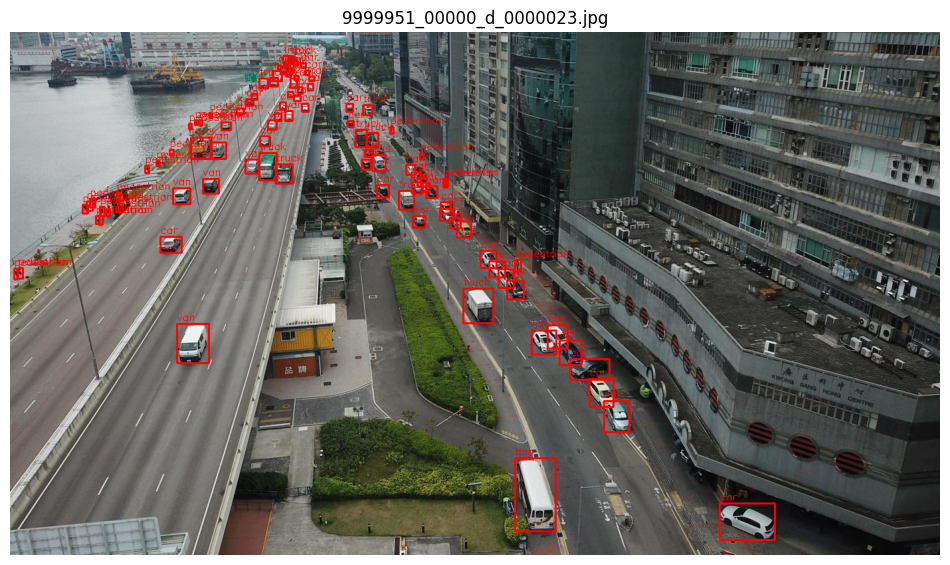

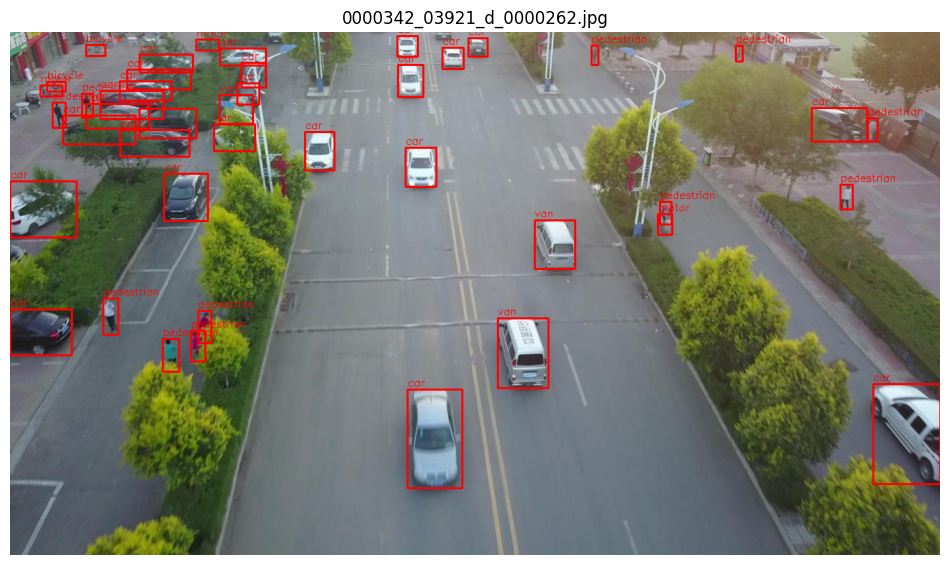

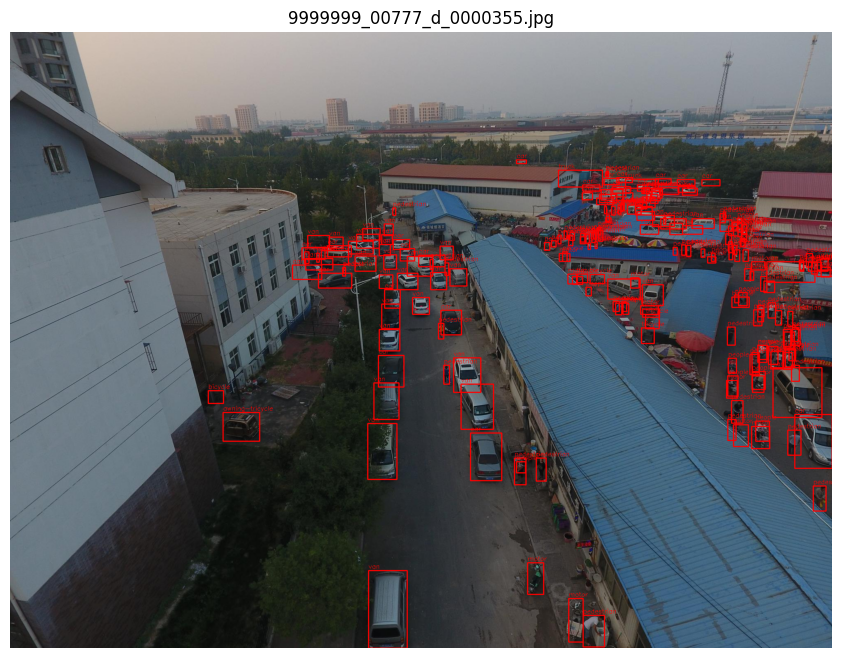

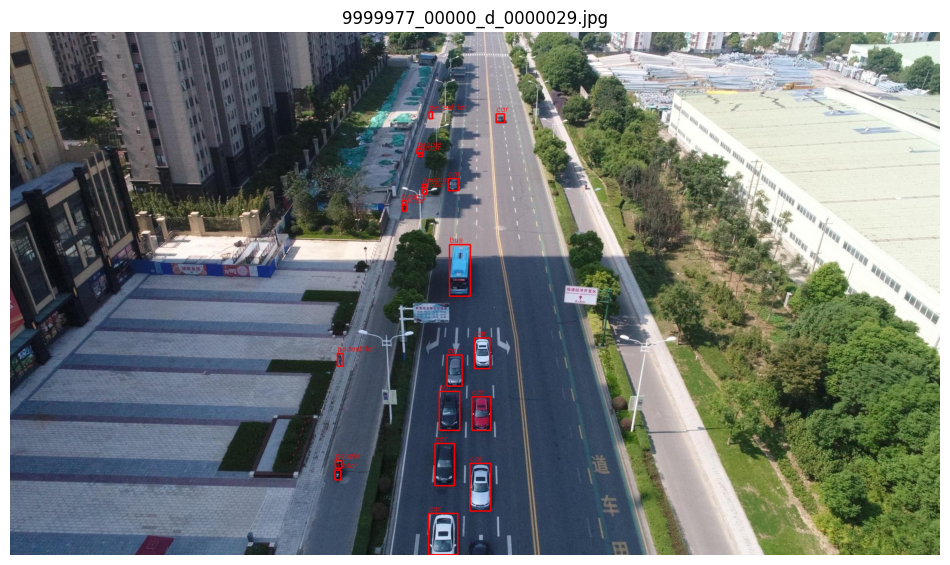

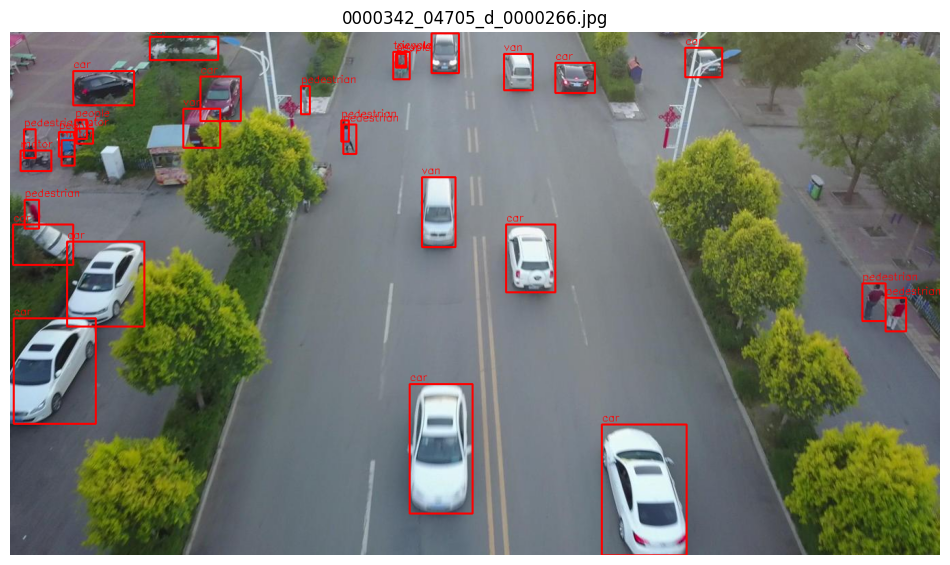


VisDrone Sınıf İsimleri:
0: ignored regions
1: pedestrian
2: people
3: bicycle
4: car
5: van
6: truck
7: tricycle
8: awning-tricycle
9: bus
10: motor


In [2]:
import os
import cv2
import matplotlib.pyplot as plt

images_dir = '/kaggle/input/visdrone-dataset/VisDrone2019-DET-train/VisDrone2019-DET-train/images'
annotations_dir = '/kaggle/input/visdrone-dataset/VisDrone2019-DET-train/VisDrone2019-DET-train/annotations'

class_names = {
    0: 'ignored regions',
    1: 'pedestrian',
    2: 'people',
    3: 'bicycle',
    4: 'car',
    5: 'van',
    6: 'truck',
    7: 'tricycle',
    8: 'awning-tricycle',
    9: 'bus',
    10: 'motor'
}

sample_images = os.listdir(images_dir)[:5]

for img_name in sample_images:
    
    img_path = os.path.join(images_dir, img_name)
    ann_path = os.path.join(annotations_dir, img_name.replace('.jpg', '.txt'))
    
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    if os.path.exists(ann_path):
        with open(ann_path, 'r') as f:
            lines = f.readlines()
        
        for line in lines:
            x, y, w, h, score, class_id, truncation, occlusion = map(int, line.strip().split(','))
            
            
            if class_id == 0:
                continue

            
            cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
            
            # Class adını yaz
            class_name = class_names.get(class_id, f"Class {class_id}")
            cv2.putText(img, class_name, (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 1)
    
    
    plt.figure(figsize=(12,8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(img_name)
    plt.show()


print("\nVisDrone Sınıf İsimleri:")
for class_id, class_name in class_names.items():
    print(f"{class_id}: {class_name}")
    


In [3]:
import torch
import torch.nn as nn
from ultralytics import YOLO
from ultralytics.nn.modules import Conv


class ChannelAttention(nn.Module):
    def __init__(self, in_channels, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.shared_mlp = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // ratio, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_channels // ratio, in_channels, 1, bias=False),
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.shared_mlp(self.avg_pool(x))
        max_out = self.shared_mlp(self.max_pool(x))
        return x * self.sigmoid(avg_out + max_out)


class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)  
        concat = torch.cat([avg_out, max_out], dim=1)
        return x * self.sigmoid(self.conv(concat))


class CBAM(nn.Module):
    def __init__(self, in_channels, ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_channels, ratio)
        self.spatial_attention = SpatialAttention(kernel_size)

    def forward(self, x):
        x = self.channel_attention(x)
        x = self.spatial_attention(x)
        return x


class CBAMBlock(nn.Module):
    def __init__(self, c1, c2):
        super().__init__()
        self.conv = Conv(c1, c2)
        self.cbam = CBAM(c2)

    def forward(self, x):
        return self.cbam(self.conv(x))


class CustomYOLO(YOLO):
    def __init__(self, cfg='yolov8m.yaml'):
        super().__init__(cfg)
        self.modify_model()

    def modify_model(self):
        for i, layer in enumerate(self.model.model):
            if isinstance(layer, Conv):  # Conv bloklarını CBAM ile değiştir
                c1, c2 = layer.conv.in_channels, layer.conv.out_channels
                self.model.model[i] = CBAMBlock(c1, c2)


model = CustomYOLO('yolov8m.yaml')


print(model)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
CustomYOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): CBAMBlock(
        (conv): Conv(
          (conv): Conv2d(3, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cbam): CBAM(
          (channel_attention): ChannelAttention(
            (avg_pool): AdaptiveAvgPool2d(output_size=1)
            (max_pool): AdaptiveMaxPool2d(output_size=1)
            (shared_mlp): Sequential(
              (0): Conv2d(48, 3, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): ReLU()
              (2): Conv2d(3, 48

In [ ]:
model.train(
    data='/kaggle/input/visdrone-dataset/VisDrone.yaml',  # Veri seti
    epochs=100,  # Eğitim epoch sayısı
    batch=16,  # Batch size
    imgsz=640  # Görüntü boyutu
)

Ultralytics 8.3.118 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.yaml, data=/kaggle/input/visdrone-dataset/VisDrone.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=

train: Scanning /kaggle/working/datasets/VisDrone/VisDrone2019-DET-train/labels.cache... 6471 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6471/6471 [00:00<?, ?it/s]

train: /kaggle/working/datasets/VisDrone/VisDrone2019-DET-train/images/0000137_02220_d_0000163.jpg: 1 duplicate labels removed
train: /kaggle/working/datasets/VisDrone/VisDrone2019-DET-train/images/0000140_00118_d_0000002.jpg: 1 duplicate labels removed
train: /kaggle/working/datasets/VisDrone/VisDrone2019-DET-train/images/9999945_00000_d_0000114.jpg: 1 duplicate labels removed
train: /kaggle/working/datasets/VisDrone/VisDrone2019-DET-train/images/9999987_00000_d_0000049.jpg: 1 duplicate labels removed


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1131.5±726.8 MB/s, size: 131.6 KB)


val: Scanning /kaggle/working/datasets/VisDrone/VisDrone2019-DET-val/labels.cache... 548 images, 0 backgrounds, 0 corrupt: 100%|██████████| 548/548 [00:00<?, ?it/s]


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train3
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      14.2G      4.512      4.381      3.407        674        640: 100%|██████████| 405/405 [04:28<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.51it/s]

                   all        548      38759     0.0252     0.0408     0.0153    0.00503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      14.6G      2.742        2.4      1.647        872        640: 100%|██████████| 405/405 [04:25<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.33it/s]

                   all        548      38759      0.289      0.101     0.0629     0.0272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      14.1G      2.243      1.971      1.327        409        640: 100%|██████████| 405/405 [04:25<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.46it/s]

                   all        548      38759      0.254      0.145      0.104     0.0483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      14.2G       2.02      1.734      1.206        610        640: 100%|██████████| 405/405 [04:24<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.67it/s]

                   all        548      38759      0.222      0.175      0.137     0.0671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      14.6G      1.859      1.558      1.146        591        640: 100%|██████████| 405/405 [04:24<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.69it/s]

                   all        548      38759      0.264      0.202      0.173     0.0901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      15.2G       1.76       1.45      1.109        466        640: 100%|██████████| 405/405 [04:24<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.74it/s]

                   all        548      38759      0.266      0.215      0.182     0.0962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      14.6G      1.695      1.373      1.089        274        640: 100%|██████████| 405/405 [04:23<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.72it/s]

                   all        548      38759      0.292       0.23      0.208      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      14.2G      1.629      1.305      1.064        335        640: 100%|██████████| 405/405 [04:23<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.75it/s]

                   all        548      38759      0.324      0.259      0.235      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      14.9G      1.597      1.267      1.054        646        640: 100%|██████████| 405/405 [04:24<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.72it/s]

                   all        548      38759      0.323      0.274      0.243      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      14.2G      1.545      1.222       1.04        634        640: 100%|██████████| 405/405 [04:24<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.76it/s]

                   all        548      38759       0.34      0.271      0.254      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      15.5G      1.527      1.194      1.034        505        640: 100%|██████████| 405/405 [04:24<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.72it/s]

                   all        548      38759      0.358       0.28      0.257      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      14.2G      1.497      1.162      1.026        629        640: 100%|██████████| 405/405 [04:24<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.73it/s]

                   all        548      38759      0.394      0.281      0.273      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      14.3G      1.487      1.143      1.022        706        640: 100%|██████████| 405/405 [04:24<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.75it/s]

                   all        548      38759      0.371       0.29      0.274      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      14.6G      1.455      1.111      1.009        475        640: 100%|██████████| 405/405 [04:24<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.76it/s]

                   all        548      38759      0.406      0.289      0.285      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      14.1G      1.455      1.104      1.007        648        640: 100%|██████████| 405/405 [04:24<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.77it/s]

                   all        548      38759       0.39      0.307      0.296      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      14.2G      1.436      1.083          1        774        640: 100%|██████████| 405/405 [04:24<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.77it/s]

                   all        548      38759      0.407      0.305      0.299       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      14.8G      1.413      1.061     0.9971        353        640: 100%|██████████| 405/405 [04:24<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.78it/s]

                   all        548      38759      0.404      0.308        0.3       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      14.2G      1.409      1.052     0.9933        669        640: 100%|██████████| 405/405 [04:24<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.78it/s]

                   all        548      38759      0.412      0.314      0.306      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      14.9G      1.395      1.044     0.9895        818        640: 100%|██████████| 405/405 [04:24<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.76it/s]


                   all        548      38759      0.403      0.321      0.312      0.179

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      14.1G      1.382      1.026     0.9854        494        640: 100%|██████████| 405/405 [04:25<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.75it/s]

                   all        548      38759      0.415      0.321      0.308      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      14.4G      1.372      1.015     0.9831        307        640: 100%|██████████| 405/405 [04:25<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.75it/s]

                   all        548      38759      0.423      0.319      0.316      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100        14G      1.371      1.009     0.9809        359        640: 100%|██████████| 405/405 [04:25<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.71it/s]

                   all        548      38759      0.428      0.324      0.321      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      14.7G       1.37      1.007     0.9816        595        640: 100%|██████████| 405/405 [04:25<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.73it/s]

                   all        548      38759      0.429      0.331      0.326       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      15.1G      1.351     0.9902      0.977        793        640: 100%|██████████| 405/405 [04:25<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.70it/s]

                   all        548      38759      0.431       0.33      0.331      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      15.5G      1.332     0.9705     0.9727        555        640: 100%|██████████| 405/405 [04:25<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.77it/s]

                   all        548      38759       0.45      0.337      0.337      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      14.5G      1.341     0.9776      0.975        510        640: 100%|██████████| 405/405 [04:25<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.72it/s]

                   all        548      38759      0.443      0.335      0.332      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      15.1G      1.325     0.9647     0.9691        404        640: 100%|██████████| 405/405 [04:25<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.76it/s]

                   all        548      38759      0.435      0.338      0.335      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      14.4G      1.322     0.9571     0.9697        877        640: 100%|██████████| 405/405 [04:25<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.72it/s]

                   all        548      38759      0.449      0.344      0.345      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      14.2G      1.308     0.9408     0.9646        456        640: 100%|██████████| 405/405 [04:25<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.76it/s]

                   all        548      38759      0.448      0.344      0.344      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      14.3G      1.303     0.9377     0.9643        422        640: 100%|██████████| 405/405 [04:24<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.75it/s]

                   all        548      38759      0.454      0.353      0.351      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      14.3G      1.304     0.9345     0.9635        543        640: 100%|██████████| 405/405 [04:25<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.71it/s]

                   all        548      38759      0.455      0.348      0.351      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      14.6G      1.299     0.9326     0.9611        494        640: 100%|██████████| 405/405 [04:24<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.79it/s]

                   all        548      38759      0.449      0.349      0.348      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100        14G      1.297     0.9262       0.96        393        640: 100%|██████████| 405/405 [04:24<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.78it/s]

                   all        548      38759      0.471      0.348      0.353      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      14.3G      1.288     0.9134     0.9582        564        640: 100%|██████████| 405/405 [04:24<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.77it/s]

                   all        548      38759      0.462       0.36      0.362      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      14.7G      1.279     0.9108     0.9578        498        640: 100%|██████████| 405/405 [04:25<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.71it/s]

                   all        548      38759      0.462      0.355      0.361      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      14.2G      1.273     0.9018     0.9547        587        640: 100%|██████████| 405/405 [04:24<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.80it/s]

                   all        548      38759       0.45      0.358      0.358      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      15.2G      1.271     0.8987     0.9534        634        640: 100%|██████████| 405/405 [04:24<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.77it/s]

                   all        548      38759      0.477      0.357      0.364      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      14.1G      1.266     0.8933     0.9519        701        640: 100%|██████████| 405/405 [04:24<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.78it/s]

                   all        548      38759      0.465       0.37      0.365      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      14.3G      1.273     0.8955     0.9516        604        640: 100%|██████████| 405/405 [04:24<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.69it/s]

                   all        548      38759      0.482      0.362      0.366      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      14.2G      1.264      0.887     0.9529        691        640: 100%|██████████| 405/405 [04:24<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.79it/s]

                   all        548      38759      0.475      0.363      0.372      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      14.4G      1.256      0.878     0.9483        554        640: 100%|██████████| 405/405 [04:24<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.70it/s]

                   all        548      38759      0.476      0.364      0.369       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      13.9G      1.248     0.8756     0.9467        353        640: 100%|██████████| 405/405 [04:24<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.77it/s]

                   all        548      38759      0.474      0.363      0.368       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100        15G      1.248     0.8737     0.9455        446        640: 100%|██████████| 405/405 [04:24<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.75it/s]

                   all        548      38759      0.476      0.367      0.371      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      14.3G      1.242     0.8663     0.9434        957        640: 100%|██████████| 405/405 [04:24<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.79it/s]

                   all        548      38759      0.478      0.367      0.372      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      14.6G      1.239     0.8603     0.9441        568        640: 100%|██████████| 405/405 [04:24<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.74it/s]

                   all        548      38759       0.49      0.365      0.375      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      13.9G      1.237     0.8567     0.9435        506        640: 100%|██████████| 405/405 [04:24<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.80it/s]

                   all        548      38759      0.484      0.365      0.373      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      14.6G      1.236     0.8532     0.9442        616        640: 100%|██████████| 405/405 [04:24<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.76it/s]


                   all        548      38759      0.477      0.372      0.376      0.224

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      14.8G      1.231     0.8481      0.943       1312        640: 100%|██████████| 405/405 [04:24<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.82it/s]

                   all        548      38759      0.475      0.373      0.377      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      14.7G      1.237     0.8487     0.9434       1345        640:  35%|███▌      | 143/405 [01:33<02:49,  1.55it/s]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


     49/100      13.9G      1.225     0.8425     0.9404        588        640: 100%|██████████| 405/405 [04:33<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.80it/s]

                   all        548      38759      0.483      0.374      0.379      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      14.6G      1.229     0.8431      0.943        434        640: 100%|██████████| 405/405 [04:24<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.78it/s]

                   all        548      38759      0.493      0.378      0.382       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      14.6G      1.226     0.8401     0.9385        673        640: 100%|██████████| 405/405 [04:23<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.81it/s]

                   all        548      38759      0.494      0.381      0.386      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      14.4G      1.216     0.8333     0.9392        436        640: 100%|██████████| 405/405 [04:24<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.82it/s]

                   all        548      38759      0.489      0.379      0.385      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      14.8G      1.217      0.831     0.9392        593        640: 100%|██████████| 405/405 [04:24<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.82it/s]

                   all        548      38759      0.495      0.375      0.384      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      14.9G      1.211     0.8265      0.936        618        640: 100%|██████████| 405/405 [04:24<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.82it/s]

                   all        548      38759      0.495      0.379      0.388      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      14.6G      1.205     0.8209     0.9371        846        640: 100%|██████████| 405/405 [04:24<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.80it/s]

                   all        548      38759      0.488      0.378      0.384      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      14.6G      1.204     0.8164     0.9351        822        640: 100%|██████████| 405/405 [04:24<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.81it/s]

                   all        548      38759      0.493      0.384      0.386      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      15.4G      1.206     0.8158     0.9349        709        640: 100%|██████████| 405/405 [04:24<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.78it/s]

                   all        548      38759      0.497      0.379      0.387      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      14.3G      1.199     0.8073     0.9341        442        640: 100%|██████████| 405/405 [04:24<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.82it/s]

                   all        548      38759      0.496      0.384      0.389      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      14.4G      1.196     0.8076     0.9326        438        640: 100%|██████████| 405/405 [04:23<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.82it/s]

                   all        548      38759      0.496       0.38      0.389      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      14.4G      1.193     0.8055     0.9303        747        640: 100%|██████████| 405/405 [04:24<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.83it/s]

                   all        548      38759      0.506      0.384      0.391      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      14.6G       1.19     0.7966     0.9301        627        640: 100%|██████████| 405/405 [04:24<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.79it/s]

                   all        548      38759      0.497      0.385      0.391      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      14.8G      1.192     0.7974     0.9324        521        640: 100%|██████████| 405/405 [04:23<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.82it/s]

                   all        548      38759      0.492      0.387      0.392      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      14.7G      1.184     0.7961      0.928        427        640: 100%|██████████| 405/405 [04:24<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.82it/s]

                   all        548      38759      0.505      0.382      0.392      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      14.5G      1.185     0.7874     0.9308        389        640: 100%|██████████| 405/405 [04:23<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.82it/s]

                   all        548      38759      0.507      0.385      0.398      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      14.8G      1.182     0.7877     0.9297        550        640: 100%|██████████| 405/405 [04:23<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.81it/s]

                   all        548      38759      0.515      0.385      0.397       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      14.6G      1.182     0.7905     0.9285       1280        640:  74%|███████▍  | 301/405 [03:17<01:07,  1.53it/s]